# ELASTICC2 classifier training

## Step 1: Import enough high-SNR samples per type 

In [1]:
import glob, os
import numpy as np
from superphot_plus.lightcurve import Lightcurve
from superphot_plus.format_data_ztf import tally_each_class

In [2]:
labels_to_classes = {
    "SNIa-SALT3": 10,
    "SNIa-91bg": 11,
    "SNIax": 12,
    "SNIb": 20,
    "SNIb-host": 21,
    "SNIcBL-host": 27,
    "SNIc": 25,
    "SNIc-host": 26,
    "SNII-NMF": 30,
    "SNII": 31,
    "SNII-host": 32,
    "SNIIn": 35,
    "SNIIn-host": 36,
    "SNIIb-host": 37,
    "SLSNI-host": 40,
    "TDE": 42,
    "ILOT": 45,
    "CART": 46,
    "KN-K17": 50,
    "KN-B19": 51,
    "PISN": 59,
    "CLAGN": 60,
    "RRL": 80,
    "Mdwarf": 82,
    "EB": 83,
    "dwarf-nova": 84,
    "uLens-single": 87,
    "uLens-single2": 88,
    "uLens-binary": 89,
    "Cepheid": 90,
    "DSCT": 91,
}
classes_to_labels = {labels_to_classes[x] : x for x in labels_to_classes}

generic_label_matching = {
    "SNIa-SALT3": "SN Ia",
    "SNIa-91bg": "SN Ia",
    "SNIax": "SN Iax",
    "SNIb": "SN Ibc",
    "SNIb-host": "SN Ibc",
    "SNIcBL-host": "SN Ibc",
    "SNIc": "SN Ibc",
    "SNIc-host": "SN Ibc",
    "SNII-NMF": "SN II",
    "SNII": "SN II",
    "SNII-host": "SN II",
    "SNIIn": "SN II",
    "SNIIn-host": "SN II",
    "SNIIb-host": "SN II",
    "SLSNI-host": "SLSN",
    "TDE": "TDE",
    "ILOT": "ILOT",
    "CART": "CART",
    "KN-K17": "KN",
    "KN-B19": "KN",
    "PISN": "PISN",
    "CLAGN": "CLAGN",
    "RRL": "RRL",
    "Mdwarf": "Mdwarf",
    "EB": "EB",
    "dwarf-nova": "Dwarf nova",
    "uLens-single": "uLens",
    "uLens-single2": "uLens",
    "uLens-binary": "uLens",
    "Cepheid": "Cepheid",
    "DSCT": "DSCT",
}
labels_to_classes_elasticc = {
    "SNIa": [10, 11],
    "SNIbc": [20, 21, 25, 26, 27],
    "SNII": [31, 32, 35, 36],
    
}

In [3]:
data_dir = "../../../../elasticc2_data/elasticc2_dataset_preprocessed"
all_lc_files = glob.glob(os.path.join(data_dir, "*", "*.npz"))

lcs = []
classes = []
for lc_fn in all_lc_files:
    lc = Lightcurve.from_file(lc_fn)
    if lc.times is None:
        continue
    lcs.append(lc)
    c = int(lc.sn_class)
    if c not in classes and c not in classes_to_labels:
        print(lc_fn, c)
    classes.append(c)

labels = [classes_to_labels[x] for x in classes]
labels_general = [generic_label_matching[x] for x in labels]
tally_each_class(labels_general)

PISN: 2038
CLAGN: 2454
SN Ia: 2771
SN Ibc: 3586
CART: 171
SN II: 5617
KN: 7
EB: 1609
uLens: 508
DSCT: 722
TDE: 1613
SN Iax: 532
Mdwarf: 8
Cepheid: 479
SLSN: 2006
RRL: 495
ILOT: 219
Dwarf nova: 146



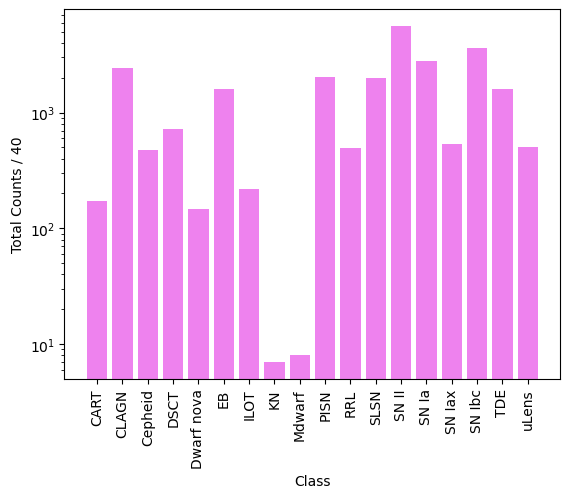

In [4]:
# make data histogram
import matplotlib.pyplot as plt
labels_unique, label_cts = np.unique(labels_general, return_counts=True)
plt.bar(labels_unique, label_cts, color="violet")
plt.yscale("log")
plt.ylabel("Total Counts / 40")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.show()

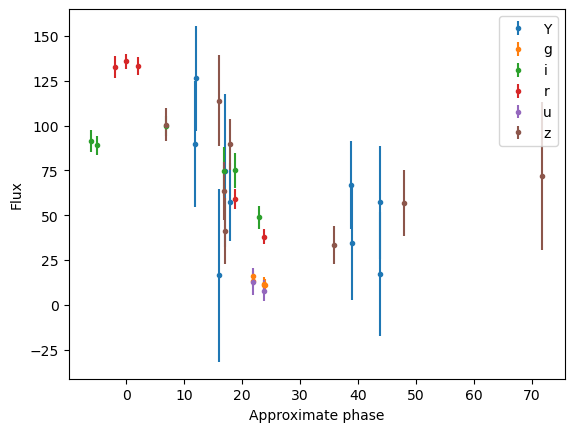

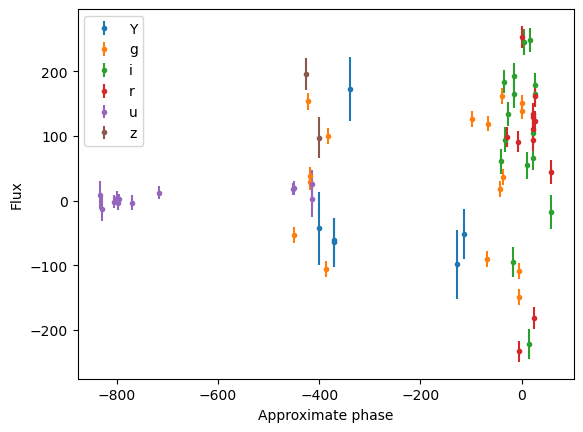

In [5]:
import matplotlib.pyplot as plt

# plot some light curves
Ia_lc_fn = glob.glob(os.path.join(data_dir, "ELASTICC2_TRAIN_02_SNIa-SALT3", "*.npz"))[0]
Ia_lc = Lightcurve.from_file(Ia_lc_fn)
for unique_b in np.unique(Ia_lc.bands):
    idxs = Ia_lc.bands == unique_b
    plt.errorbar(
        Ia_lc.times[idxs],
        Ia_lc.fluxes[idxs],
        yerr=Ia_lc.flux_errors[idxs],
        fmt=".",
        label=unique_b
    )
plt.xlabel("Approximate phase")
plt.ylabel("Flux")
plt.legend()
plt.show()


# plot some light curves
eb_lc_fn = glob.glob(os.path.join(data_dir, "ELASTICC2_TRAIN_02_EB", "*.npz"))[1]
eb_lc = Lightcurve.from_file(eb_lc_fn)
for unique_b in np.unique(eb_lc.bands):
    idxs = eb_lc.bands == unique_b
    plt.errorbar(
        eb_lc.times[idxs],
        eb_lc.fluxes[idxs],
        yerr=eb_lc.flux_errors[idxs],
        fmt=".",
        label=unique_b
    )
plt.xlabel("Approximate phase")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [6]:
from superphot_plus.samplers.numpyro_sampler import NumpyroSampler
from superphot_plus.surveys.surveys import Survey

import time
# benchmark fitting
svi_sampler = NumpyroSampler()
survey = Survey.LSST()
priors = survey.priors

"""
#make sure fitting is working
all_band_fits = svi_sampler.run_single_curve(
    Ia_lc,
    priors,
    None
)
"""

'\n#make sure fitting is working\nall_band_fits = svi_sampler.run_single_curve(\n    Ia_lc,\n    priors,\n    None\n)\n'

In [7]:
from superphot_plus.plotting.lightcurves import plot_sampling_lc_fit

band_fit_order = ["r", "i", "z", "g", "Y", "u"]
runtimes = []
red_chisqs = []
for i in range(2, 7):
    bands_include = band_fit_order[:i]
    lc_snipped = Ia_lc.filter_by_band(bands_include, in_place=False)
    prior_snipped = priors.filter_by_band(bands_include, in_place=False)
    start_time = time.time()
    snipped_fits = svi_sampler.run_multi_curve(
        [lc_snipped,]*20,
        prior_snipped,
        None
    )[0]
    ignore_idxs = lc_snipped.flux_errors == 1e10
    plot_sampling_lc_fit(
        str(lc_snipped.name)+"_"+str(len(bands_include)),
        ".",
        lc_snipped.times[~ignore_idxs],
        lc_snipped.fluxes[~ignore_idxs],
        lc_snipped.flux_errors[~ignore_idxs],
        lc_snipped.bands[~ignore_idxs],
        snipped_fits.samples,
        prior_snipped.band_order,
        prior_snipped.reference_band,
        sampling_method="svi",
        file_type="pdf",
        custom_formatting=None,
    )
    # best-fit params
    print(np.mean(snipped_fits.samples, axis=0))
    runtimes.append(time.time() - start_time)
    red_chisqs.append(np.mean(snipped_fits.samples[:,-1]))

Running numpyro with seed=2948134800
0
[ 1.51197763e+02  5.17646851e-03  1.10915838e+01 -9.20222581e+00
  3.28614370e+00  1.77294058e+01  2.36211608e-02  8.72174008e-01
  1.00538309e+00  1.02873116e+00  1.00008084e+00  1.33746288e+00
  1.44002293e+00  1.04597771e+00 -3.67252906e+00]
Running numpyro with seed=1620749508
0


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:222: RuntimeWarning: overflow encountered in exp
  / (1.0 + np.exp(-phase_b / tau_rise_b))


[ 1.51051134e+02  5.00130878e-03  9.83692506e+00 -8.62537657e+00
  3.02031976e+00  1.84987805e+01  2.42133847e-02  8.83109507e-01
  9.95536588e-01  1.01632274e+00  9.99982098e-01  1.27685535e+00
  1.37419301e+00  9.93904134e-01  8.74170530e-01  1.00433212e+00
  1.00532052e+00  9.99968901e-01  1.01884908e+00  1.56005591e+00
  1.00340777e+00 -4.18822316e+00]
Running numpyro with seed=2617040934
0


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:222: RuntimeWarning: overflow encountered in exp
  / (1.0 + np.exp(-phase_b / tau_rise_b))


[ 7.52185003e-01  9.98431528e-01  9.93075527e-01  1.00003659e+00
  1.00631515e+00  5.53276273e-01  9.62677015e-01  1.51679701e+02
  5.02326488e-03  9.40024459e+00 -8.59869277e+00  2.96900295e+00
  1.86074013e+01  2.50107478e-02  8.92761619e-01  1.00674685e+00
  1.01999846e+00  1.00001627e+00  1.26138057e+00  1.35994044e+00
  9.55310669e-01  8.90752997e-01  1.00431492e+00  1.01047448e+00
  1.00003352e+00  1.03376554e+00  1.54062653e+00  1.02162234e+00
 -5.28161164e+00]
Running numpyro with seed=1188557172
0


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:222: RuntimeWarning: overflow encountered in exp
  / (1.0 + np.exp(-phase_b / tau_rise_b))


[ 7.59860869e-01  9.96300102e-01  9.75546821e-01  9.99979925e-01
  9.99965685e-01  5.63178012e-01  1.04398170e+00  1.50118712e+02
  4.94304989e-03  9.27129952e+00 -8.32665836e+00  2.81422343e+00
  1.87554637e+01  3.25193100e-02  8.92892491e-01  9.99200121e-01
  1.01729855e+00  9.99945298e-01  1.22074867e+00  1.35111626e+00
  8.68720922e-01  8.96188500e-01  1.00169559e+00  1.00662465e+00
  9.99991836e-01  1.01835592e+00  1.52809578e+00  9.94963934e-01
  1.03875978e+00  9.97996612e-01  1.00882554e+00  9.99983243e-01
  9.91610618e-01  1.33570619e+00  9.93153446e-01 -5.41711814e+00]
Running numpyro with seed=1474481054
0


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:222: RuntimeWarning: overflow encountered in exp
  / (1.0 + np.exp(-phase_b / tau_rise_b))


[ 7.70242616e-01  1.00123198e+00  9.93555596e-01  1.00025212e+00
  1.00249841e+00  5.93763886e-01  1.04305964e+00  7.87409897e-01
  1.00420837e+00  9.75399612e-01  1.00026434e+00  1.01103686e+00
  6.23521929e-01  1.10177991e+00  1.45976372e+02  4.92740269e-03
  9.38657615e+00 -7.86775236e+00  2.29903767e+00  1.78704874e+01
  4.00232252e-02  9.04073296e-01  1.00377112e+00  1.02446138e+00
  1.00027582e+00  1.20295350e+00  1.41737326e+00  9.15245955e-01
  9.24573643e-01  1.00231964e+00  1.00974836e+00  1.00028401e+00
  1.01140760e+00  1.56353150e+00  9.91997504e-01  1.07391241e+00
  1.00196649e+00  1.01094137e+00  1.00021765e+00  1.00359716e+00
  1.36274281e+00  9.86974374e-01 -5.45915120e+00]


In [8]:
runtimes_single = [] 
for i in range(2, 7):
    bands_include = band_fit_order[:i]
    lc_snipped = Ia_lc.filter_by_band(bands_include)
    prior_snipped = priors.filter_by_band(bands_include, in_place=False)
    start_time = time.time()
    svi_sampler.run_single_curve(
        lc_snipped,
        prior_snipped,
        None
    )
    runtimes_single.append(time.time() - start_time)


Running numpyro with seed=3597946497
0
Running numpyro with seed=657336803
0
Running numpyro with seed=3247329620
0
Running numpyro with seed=3257457473
0
Running numpyro with seed=2487583432
0


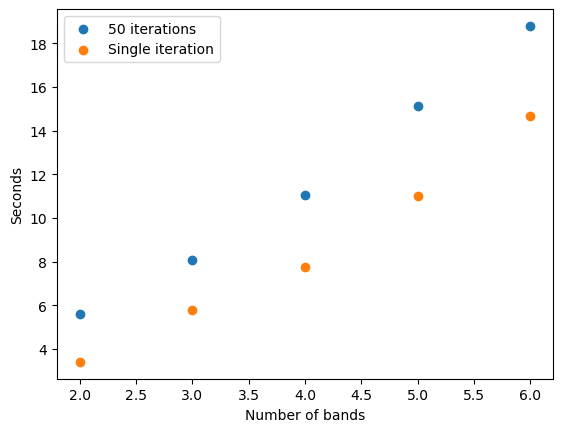

In [9]:
plt.scatter(np.arange(len(runtimes))+2, runtimes, label="50 iterations")
plt.scatter(np.arange(len(runtimes_single))+2, runtimes_single, label="Single iteration")
plt.ylabel("Seconds")
plt.xlabel("Number of bands")
plt.legend()
plt.show()

In [16]:
# run fitting on all SN-like objects
data_dir = "../../../../elasticc2_data/elasticc2_dataset_preprocessed"
fits_dir = "../../../../elasticc2_data/elasticc2_sn_fits"

sn_subdirs = [
    "ELASTICC2_TRAIN_02_SLSN-I_no_host",
    "ELASTICC2_TRAIN_02_SLSN-I+host",
    "ELASTICC2_TRAIN_02_SNIa-91bg",
    "ELASTICC2_TRAIN_02_SNIa-SALT3",
    "ELASTICC2_TRAIN_02_SNIax",
    "ELASTICC2_TRAIN_02_SNIb-Templates",
    "ELASTICC2_TRAIN_02_SNIc-Templates",
    "ELASTICC2_TRAIN_02_SNIc+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIcBL+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNII-NMF",
    "ELASTICC2_TRAIN_02_SNII-Templates",
    "ELASTICC2_TRAIN_02_SNII+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIIb+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIIn-MOSFIT",
    "ELASTICC2_TRAIN_02_SNIIn+HostXT_V19",
]
for sn_subdir in sn_subdirs:
    lcs_sn = []
    print(os.path.join(data_dir, sn_subdir))
    all_lc_files = glob.glob(
        os.path.join(data_dir, sn_subdir, "*.npz")
    )
    fits_dir_full = os.path.join(fits_dir, sn_subdir)
    os.makedirs(fits_dir_full, exist_ok=True)
    for lc_fn in all_lc_files:
        lc = Lightcurve.from_file(lc_fn)
        if lc.times is None:
            continue
        if len(lc.fluxes[lc.bands == priors.reference_band]) == 0:
            print("no r points")
            continue
        if os.path.exists(
            os.path.join(fits_dir_full, str(lc.name)+"_eqwt_svi.npz")
        ):
            continue
        lcs_sn.append(lc)
    snipped_fits = svi_sampler.run_multi_curve(
        lcs_sn,
        priors,
        None
    )
    for snipped_fit in snipped_fits:
        snipped_fit.save_to_file(fits_dir_full)
    

../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SLSN-I_no_host
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SLSN-I+host
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIa-91bg
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIa-SALT3
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIax
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIb-Templates
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIc-Templates
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIc+HostXT_V19
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNIcBL+HostXT_V19
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNII-NMF
../../../../elasticc2_data/elasticc2_dataset_preprocessed/ELASTICC2_TRAIN_02_SNII-Templates
../../../..